In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Design Generator

In [3]:
class Generator(nn.Module):
    """docstring for Generator."""
    def __init__(self):
        super(Generator, self).__init__()
        self.d = 128
        self.Tconv1 = nn.ConvTranspose2d(100, self.d * 8, 4, 1, 0) #(batch, 4, 4, 1024)
        self.batch1 = nn.BatchNorm2d(self.d * 8)
        self.Tconv2 = nn.ConvTranspose2d(self.d * 8, self.d * 4, kernel_size=4, stride=2, padding=1) #(B, 8, 8, 512)
        self.batch2 = nn.BatchNorm2d(self.d * 4)
        self.Tconv3 = nn.ConvTranspose2d(self.d * 4, self.d * 2, kernel_size=4, stride=2, padding=1) #(B, 16, 16, 256)
        self.batch3 = nn.BatchNorm2d(self.d * 2)
        self.Tconv4 = nn.ConvTranspose2d(self.d * 2, self.d, kernel_size=4, stride=2, padding=1) #(B, 32, 32, 256)
        self.batch4 = nn.BatchNorm2d(self.d)
        self.Tconv5 = nn.ConvTranspose2d(self.d, 1, kernel_size=4, stride=2, padding=1) #(B, 64, 64, 256)
        
        
    def forward(self, z):
        z_conv = F.relu(self.batch1(self.Tconv1(z)))
        z_conv = F.relu(self.batch2(self.Tconv2(z_conv)))
        z_conv = F.relu(self.batch3(self.Tconv3(z_conv)))
        z_conv = F.relu(self.batch4(self.Tconv4(z_conv)))
        z_conv = F.tanh(self.Tconv5(z_conv))
        return z_conv
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)




# Test generator

In [4]:
z = torch.randn(100, 100).view(100, 100, 1, 1)    # fixed noise
z = Variable(z, volatile=True)
generator_test = Generator()
z_conv = generator_test.forward(z)
print(z_conv.size())

torch.Size([100, 1, 64, 64])


# Design Discriminator

In [5]:
class Discriminator(nn.Module):
    """docstring for Discriminator."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d = 128
        self.conv2D1 = nn.Conv2d(1, self.d, kernel_size=4, stride=2, padding=1)
        self.conv2D2 = nn.Conv2d(self.d, self.d * 2, kernel_size=4, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(self.d * 2)
        self.conv2D3 = nn.Conv2d(self.d * 2, self.d * 4, kernel_size=4, stride=2, padding=1)
        self.batch3 = nn.BatchNorm2d(self.d*4)
        self.conv2D4 = nn.Conv2d(self.d * 4, self.d * 8, kernel_size=4, stride=2, padding=1)
        self.batch4 = nn.BatchNorm2d(self.d * 8)
        self.conv2D5 = nn.Conv2d(self.d * 8, 1, kernel_size=4, stride=2, padding=0)

    def forward(self, x):
        x_conv = F.leaky_relu(self.conv2D1(x), 0.2)
        x_conv = F.leaky_relu(self.batch2(self.conv2D2(x_conv)), 0.2)
        x_conv = F.leaky_relu(self.batch3(self.conv2D3(x_conv)), 0.2)
        x_conv = F.leaky_relu(self.batch4(self.conv2D4(x_conv)), 0.2)
        pred = F.sigmoid(self.conv2D5(x_conv))
        return pred
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

# Test Discriminator

In [6]:
discrimintaor_test = Discriminator()
pred_z_conv = discrimintaor_test(z_conv)
print(pred_z_conv.size())

torch.Size([100, 1, 1, 1])


# Load dataset

In [7]:
# MNIST dataset

#transform = transforms.Compose(
#    [torchvision.transforms.Resize((64, 64)),
#        transforms.ToTensor()],)

transform = transforms.Compose([
        transforms.Scale((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

# Test on images

In [8]:
# get some random training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(images.size())
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))

torch.Size([128, 1, 64, 64])


In [9]:
img = Variable(images)
print(img.size())
pred_img_conv = discrimintaor_test(img)
print(pred_img_conv.size())

torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 1, 1])


# Define model

In [10]:
def extract(v):
    return v.data.storage().tolist()

batch_size = 128

d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1
d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.5, 0.999)
print_interval = 1
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

#Define network
DCG = Generator()
DCD = Discriminator()
DCG.cuda()
DCD.cuda()
DCG.weight_init(mean=0.0, std=0.02)
DCD.weight_init(mean=0.0, std=0.02)

#Define Learning
criterion = nn.BCELoss()
d_optimizer = optim.Adam(DCD.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(DCG.parameters(), lr=g_learning_rate, betas=optim_betas)
G_loss = []
D_loss = []



# Training

In [11]:
n_epoch = 20
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):
        DCD.zero_grad()

        #Compute gradient fake data
        img, _ = data
        batch_size = img.size()[0]
        real_data = Variable(img.cuda())
        real_output = DCD(real_data)
        real_error = criterion(real_output.view(batch_size), Variable(torch.ones(batch_size).cuda()))
        real_error.backward()

        #compute grad fake data
        z = torch.randn(batch_size, 100).view(batch_size, 100, 1, 1)    # fixed noise
        d_noise = Variable(z.cuda(), volatile = False) #volatile ? To compute grad ==> volatile = False
        fake_output = DCG(d_noise).detach()
        fake_class = DCD(fake_output)
        fake_error = criterion(fake_class.view(batch_size), Variable(torch.zeros(batch_size).cuda())) #fake_class.view(100) ok ?
        fake_error.backward()
        d_optimizer.step()

        DCG.zero_grad()

        z = torch.randn(batch_size, 100).view(batch_size, 100, 1, 1)    # fixed noise
        g_noise = Variable(z.cuda())
        g_fake_data = DCG(g_noise)
        g_fake_decision = DCD(g_fake_data)
        g_error = criterion(g_fake_decision.view(batch_size), Variable(torch.ones(batch_size).cuda()))
        g_error.backward()
        g_optimizer.step()
        
        G_loss.append(extract(g_error)[0])
        D_loss.append(extract(real_error)[0] + extract(fake_error)[0])


        #print(i)
    print("%s: D: %s/%s G: %s " % (epoch + 1,
                                                    extract(real_error)[0],
                                                    extract(fake_error)[0],
                                                    extract(g_error)[0],
                                                    ))

1: D: 0.3565608561038971/0.1837068796157837 G: 1.5696182250976562 
2: D: 0.2228100448846817/0.10556858032941818 G: 2.0640623569488525 
3: D: 0.019870568066835403/0.30922412872314453 G: 4.934815883636475 
4: D: 0.4831169545650482/0.4942283630371094 G: 2.339890718460083 
5: D: 0.18890242278575897/0.8228294253349304 G: 4.000115871429443 
6: D: 0.10729490965604782/0.11810129880905151 G: 3.4674360752105713 
7: D: 0.028264880180358887/0.019606979563832283 G: 4.460666656494141 
8: D: 0.8381357192993164/0.027601713314652443 G: 2.0290119647979736 
9: D: 0.028950246050953865/0.0034779030829668045 G: 5.016067981719971 
10: D: 0.02591981552541256/0.20280539989471436 G: 4.721846103668213 
11: D: 0.030924146994948387/0.3040735423564911 G: 5.007114887237549 
12: D: 0.4921140670776367/0.047628890722990036 G: 2.9167606830596924 
13: D: 1.0145232677459717/0.022191261872649193 G: 0.34927263855934143 
14: D: 0.062181487679481506/0.18360121548175812 G: 3.8148720264434814 
15: D: 0.06254333257675171/0.08108

# Results

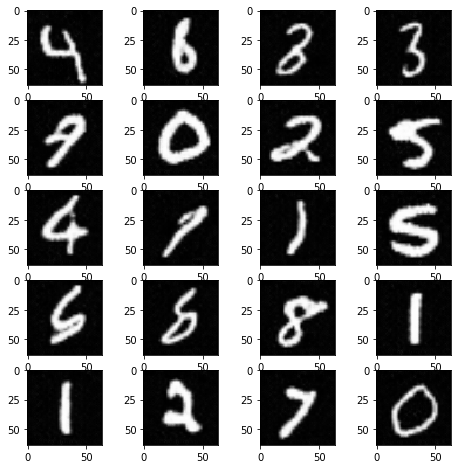

In [29]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = torch.randn(128, 100).view(128, 100, 1, 1)    # fixed noise
    z = Variable(z.cuda(), volatile=True)
    images = DCG(z)
    img = images.cpu().data
    fig.add_subplot(rows, columns, i)
    imshow(torchvision.utils.make_grid(img[0].view(64,64)))
#plt.title("DCGAN_5_epochs")
plt.show()
fig.savefig('DCGAN_20epochs.png', bbox_inches='tight')

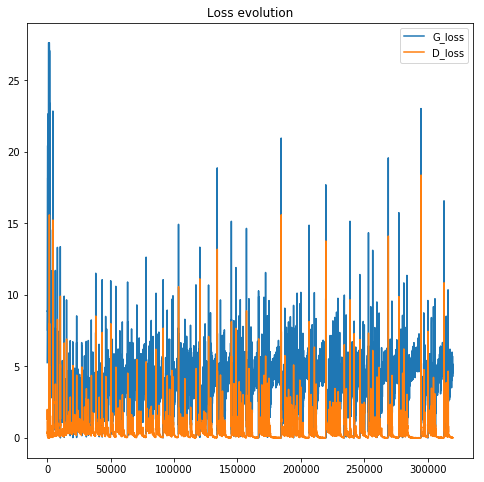

In [15]:
absc = np.linspace(0, 16000*20, len(G_loss) )
fig_loss=plt.figure(figsize=(8, 8))
plt.plot(absc, G_loss, label = "G_loss")
plt.plot(absc, D_loss, label = "D_loss")
plt.title("Loss evolution")
plt.legend()
plt.show()
fig_loss.savefig('loss_evolution_20epochs.png', bbox_inches='tight')

128


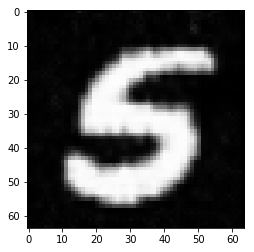

In [20]:
z = torch.randn(128, 100).view(128, 100, 1, 1)    # fixed noise
z = Variable(z.cuda(), volatile=True)
images = DCG(z)
img = images.cpu().data
print(img.size()[0])
imshow(torchvision.utils.make_grid(img[0]))
plt.show()